# Introduction

In this project, we will build a neural network of your own design to evaluate the CIFAR-10 dataset.

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform_train = transforms.Compose([
    transforms.Resize(255), 
    transforms.RandomCrop(224),         #Data Augmentation - randomly cropping image 244 x 244 as that is the input required for pretrained convolution models
    transforms.RandomHorizontalFlip(),    #Data Augemtation - randomly flipping the image
    transforms.RandomRotation(30),        #Data Augmentation - randomly rotating the image 30 degrees
    transforms.ToTensor(),                #converting the images to tensors
    transforms.Normalize([0.485,0.456,0.406], 
                        [0.229,0.224,0.225])  #normalizing the image to fit the required input for resnet50
])

#no data augmentation in the test data
transform_test = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),                #converting the images to tensors
    transforms.Normalize([0.485,0.456,0.406], 
                        [0.229,0.224,0.225])  #normalizing the image colour stations
])



# Create training set and define training dataloader
import torchvision.datasets as datasets

trainset = datasets.CIFAR10(root='./data', train = True, download = True, transform=transform_train)

#dividing the trainset into training data and validation data

train_size = int(0.8 * len(trainset))
validate_size = len(trainset) - train_size

training_set, validation_set = torch.utils.data.dataset.random_split(trainset, [train_size, validate_size])

#defining training and validation dataloader
trainloader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=True) 
validateloader = torch.utils.data.DataLoader(validation_set, batch_size=100, shuffle=True) 



# Create test set and define test dataloader
testset = datasets.CIFAR10(root='./data', train = False, download = True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)



# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We are going to use the **RESNET-50** Deep Network to help us classify the CIFAR-10 images. 

This network requires an image with 224 x 224 dimensions and normalization with **mean** of [0.485,0.456,0.406] and **std** of [0.229,0.224,0.225]

*Ref*: https://pytorch.org/vision/stable/models.html

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]

    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        mean = (0.485,0.456,0.406)
        std = (0.229,0.224,0.225)
        
        for i in range(3):
            image[i] = std[i] * image[i] + mean[i]
        
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

horse


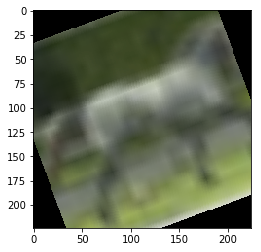

cat


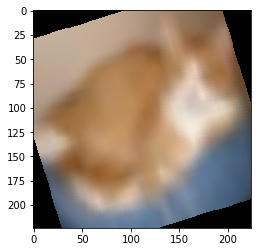

dog


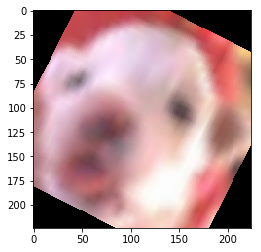

bird


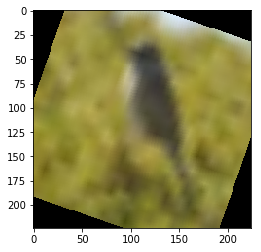

ship


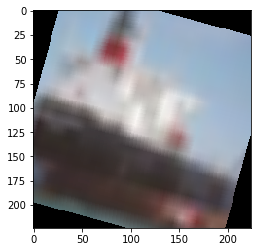

In [4]:
show5(trainloader)

In [5]:
# Explore data
for image, label in trainloader:
    print(image.shape)
    print(label.shape)
    break



torch.Size([100, 3, 224, 224])
torch.Size([100])


In [6]:
for image, label in validateloader:
    print(image.shape)
    print(label.shape)
    break


torch.Size([100, 3, 224, 224])
torch.Size([100])


In [7]:
for image, label in testloader:
    print(image.shape)
    print(label.shape)
    break


torch.Size([100, 3, 224, 224])
torch.Size([100])


The training images are loading with a *batch_size* of 100 images per batch, 3 *color channels*, and *dimension* of 224 x 224

Respectively, the training *labels* have 100 labels, one for each image in the batch.

The images are also loaded correctly in the *validation set* and the *test set*

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.

As mentioned earlier, we are going ahead with the **Resnet50** deep network for image classification.

We are going to use the *Resnet50* for transfer learning and substitute its last *Fully Connected Layer* with our own network. 

In this way, we are going to use the power of the convolution network optimized in Resnet50 on our CIFAR-10 dataset

In [8]:
#importing pretrained convolution network

from torchvision import models

model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 106357306.67it/s]


In [9]:
#checking the layers of the Resnet50 network
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

We are interested in the final layer **fc** of the network. 

This layer takes in **2048** features as input and returns **1000** classes as output.

We are going to substitute this *fc* layer with out own **Image_Classifier** layer

In [10]:
#building the NN architecture
#the fully connected layer will be the final layer in the deep network (Resnet50). 
#We will name this layer "Image_Classifier"


class Image_Classifier(nn.Module):      
    def __init__(self):
        super().__init__()
        
        #defining the layers of the fully connected Network
        
        self.input = nn.Linear(2048, 1024)   #the last layer (fc) of resnet50 taken in 2048 features 
        self.hidden1 = nn.Linear(1024, 512)  #we are only going to start with one hidden layer (ref given below)
        self.output = nn.Linear(512, 10)     #as we have 10 classes, we are going to have 10 outputs
        
        self.dropout = nn.Dropout(p = 0.2)  #defining dropout with probability of 20% to avoid overfitting
    
    def forward(self, x):
        
        #there is no need to flatten the image before feeding it into the NN
        
        #defining a forward pass
        
        x = self.dropout(F.relu(self.input(x)))
        x = self.dropout(F.relu(self.hidden1(x)))
        
        x = F.log_softmax(self.output(x), dim = 1)  #no dropout on the output layer

        return x

For a fully connected layer, we are only going to have a single *hidden layer* in the fully connected network. The reason for this is **One hidden layer is sufficient for the large majority of problems**

*Ref:* https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

Before proceeding further, we are going to freeze the parameters of all the layers of the (resnet50) model, except the last one

In [11]:
#freezing params in the pretrained network

for param in model.parameters():
    param.requires_grad = False

In [12]:
#substituting our image classifier for the last layer of the pretrained network

model.fc = Image_Classifier()

#checking if the last layer of resnet50 was substituted with our Image_Classifier

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

We can now see that the final layer of the Resnet50 has been substituted with our **Image_Classifier** fully connected layer

Specify a loss function and an optimizer, and instantiate the model.

In [13]:
criterion = nn.NLLLoss()   #NLL Loss function is used as the output is a log_softmax
optimizer = optim.SGD(model.fc.parameters(), lr = 0.001, momentum=0.5)  #using the SGD optimizer 

The **SGD** optimizer is used (with a learning rate of 0.001 and momentum of 0.5) instead of the **Adam** optimizer. 

Although the *Adam* optimizer is the best among the *adaptive optimizers* in most of the cases (ref 1), it was found that it induced *overfitting* in some cases (ref 2)

It should also be noted that the optimization was only done on the parameters of *last layer i.e. fc layer*


*ref 1:* https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e 

*ref 2:* https://www.linkedin.com/pulse/transfer-learning-model-resnet50-cifar10-yulieth-zuluaga-g%C3%B3mez/

## Running your Neural Network

In [14]:
#moving model and tensors to GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

As we are training the network on a relatively complex dataset i.e. colored images, we are going to have a higher number of *Epochs* - 30.

In [15]:
device

device(type='cuda')

In [16]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []


epochs = 30
steps = 0
printevery = 200
running_loss = 0
train_accuracy = 0

for e in range(epochs):
    
    model.to(device)     #moving model to the GPU if available
    
    for images, labels in trainloader:
        steps += 1
        images, labels = images.to(device), labels.to(device)    #moving images and labels to GPU if available
        
        optimizer.zero_grad()                 #setting gradients back to zero
        
        output = model.forward(images)        #doing a forward pass through the model and getting the output
        
        loss = criterion(output, labels)      #calculating the loss from the predicted output

        loss.backward()                       #backpropagating the loss into the network
        optimizer.step()                      #adjusting the weights in the system according to SGD

        running_loss += loss.item()

        # Calculate training accuracy
        prob = torch.exp(output)                    #taking the exp of the output as the output is log fuction
        top_prob, top_class = prob.topk(1, dim = 1) #getting the class with the highest probability
        labels = labels.view(*top_class.shape)      #adjusting the shape of labels
        equals = top_class == labels                #comparing the prediction with actual value
        equals = equals.type(torch.FloatTensor)     #converting the type to Float Tensor for clalculating mean
        
        train_accuracy += torch.mean(equals)        #calculating the accuracy of the model
        
        
        #testing the model every 250 batches
        
        if steps % printevery == 0:                    
            
            
            #printing the training loss
            print('Epoch: {}/{}..'.format(e+1, epochs))
            print('Training Loss: {:.3f}..'.format(running_loss/steps))
            print('Training accuracy: {:.3f}'.format(train_accuracy/steps))
            
            training_accuracy.append(train_accuracy/steps)

            
            model.eval()                      #model goes into eval mode to test the accuracy on the test data
            
            with torch.no_grad():             #turning off grad to speed up the process of evaluation
                valid_loss = 0
                valid_accuracy = 0
                
                for images, labels in validateloader:
                    images, labels = images.to(device), labels.to(device)  #moving images and labels to GPU
                    
                    output_test = model.forward(images)                    #running forward pass for the test data
                    loss_test = criterion(output_test, labels)             #calculating loss on output
                    
                    valid_loss += loss_test.item()
                    
                    
                    # Calculate  validation accuracy
                    prob = torch.exp(output_test)               #taking the exp of the output as the output is log fuction
                    top_prob, top_class = prob.topk(1, dim = 1) #getting the class with the highest probability
                    labels = labels.view(*top_class.shape)      #adjusting the shape of labels
                    equals = top_class == labels                #comparing the prediction with actual value
                    equals = equals.type(torch.FloatTensor)     #converting the type to Float Tensor for clalculating mean
        
                    valid_accuracy += torch.mean(equals)        #calculating the accuracy of the model
                    
            print('Validation loss: {:.3f}.. '.format(valid_loss/len(validateloader)))
            print('Validation accuracy: {:.3f}'.format(valid_accuracy/len(validateloader)))
            
            training_loss.append(running_loss/steps)
            validation_loss.append(valid_loss/len(validateloader))
            validation_accuracy.append(valid_accuracy/len(validateloader))
            
            running_loss = 0
            model.train()                     #model goes back to training mode

Epoch: 1/10..
Training Loss: 2.295..
Training accuracy: 0.134
Validation loss: 2.285.. 
Validation accuracy: 0.207
Epoch: 1/10..
Training Loss: 1.139..
Training accuracy: 0.169
Validation loss: 2.265.. 
Validation accuracy: 0.334
Epoch: 2/10..
Training Loss: 0.752..
Training accuracy: 0.203
Validation loss: 2.239.. 
Validation accuracy: 0.388
Epoch: 2/10..
Training Loss: 0.558..
Training accuracy: 0.232
Validation loss: 2.208.. 
Validation accuracy: 0.462
Epoch: 3/10..
Training Loss: 0.439..
Training accuracy: 0.261
Validation loss: 2.164.. 
Validation accuracy: 0.491
Epoch: 3/10..
Training Loss: 0.358..
Training accuracy: 0.284
Validation loss: 2.109.. 
Validation accuracy: 0.493
Epoch: 4/10..
Training Loss: 0.298..
Training accuracy: 0.302
Validation loss: 2.034.. 
Validation accuracy: 0.508
Epoch: 4/10..
Training Loss: 0.252..
Training accuracy: 0.319
Validation loss: 1.947.. 
Validation accuracy: 0.520
Epoch: 5/10..
Training Loss: 0.214..
Training accuracy: 0.332
Validation loss: 1

Plot the training loss (and validation loss/accuracy, if recorded).

''

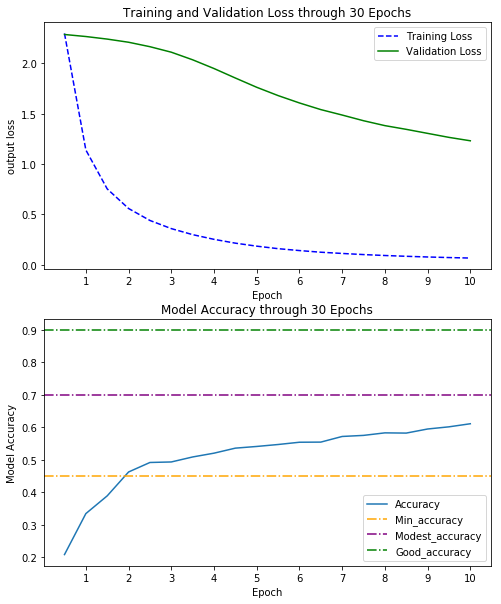

In [17]:
#Plotting the training and validation losses as well as validation accuracy

import matplotlib.pyplot as plt

plt.figure(figsize=[8,10])

plt.subplot(2,1,1)

#plotting graph for training and validation loss

plt.plot(training_loss, color = 'blue', linestyle = '--')
plt.plot(validation_loss, color = 'green')

plt.ylabel('output loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss through 30 Epochs')
plt.legend(['Training Loss', 'Validation Loss'])

xticks = np.arange(1, len(training_loss)+1, 2)
xticklabels = np.arange(1, epochs+1, 1)
plt.xticks(xticks, xticklabels);



plt.subplot(2,1,2)

#plotting graph for model accuracy

plt.plot(validation_accuracy)

plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy through 30 Epochs')

xticks = np.arange(1, len(validation_accuracy)+1, 2)
xticklabels = np.arange(1, epochs+1, 1)
plt.xticks(xticks, xticklabels)
plt.axhline(y = 0.45, color = 'orange', linestyle = '-.')
plt.axhline(y = 0.70, color = 'purple', linestyle = '-.')
plt.axhline(y = 0.90, color = 'green', linestyle = '-.')

plt.legend(['Accuracy', 'Min_accuracy', 'Modest_accuracy', 'Good_accuracy'])
;


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

In [18]:
## YOUR CODE HERE ##

test_accuracy = 0
test_loss = 0

for images, labels in testloader:
    
    model.to(device)  #moving model to GPU
    
    #flattening of images is not required
    
    images, labels = images.to(device), labels.to(device)  #moving the images and labels tensor to the GPU 
    
    model.eval()    #turning on eval mode
    
    with torch.no_grad():   #turning off gradients for faster computation
        
        output = model.forward(images)    #running a feed forward loop
        loss = criterion(output, labels)  #calculating loss
        test_loss += loss.item()          #adding the output loss
        
        #calculating the output accuracy
        
        prob = torch.exp(output)          #exp of the output as the output is log_softmax
        top_prob, top_class = prob.topk(1, dim = 1)  #finding out the top predicted class
        
        equals = top_class == labels.view(*top_class.shape) #comparing the predicted label with actual label
        equals = equals.type(torch.FloatTensor)             #converting equals to Float to calculate mean
        accuracy = torch.mean(equals)
        
        test_accuracy += accuracy


output_loss = test_loss/len(testloader)
output_accuracy = test_accuracy/len(testloader)

print('The accuracy of the model is {:.2f}%'.format(output_accuracy*100))
print('The loss of the model is {:.3f}'.format(output_loss))
    

The accuracy of the model is 63.71%
The loss of the model is 1.151


## Saving your model
Using `torch.save`, save your model for future loading.

In [19]:
#creating the checkpoint with the model details

checkpoint = {'input_size' : 2048,
              'output_size' : 10,
              'hidden_layer' : [1024, 512],
              'state_dict' : model.fc.state_dict(),
              'drop_out' : 0.2,
              'output_type' : 'log_softmax'}

In [20]:
#saving the model as Image_Classifier

torch.save(checkpoint, 'image_classifier.pth')

## Making a Recommendation

Hello Machine Learning Team,

I have some amazing news for you. By using the valuable resource of **Transfer Learning** I have been able to design a Deep Learning Network that provides an accuracy of around **75%** on the CIFAR-10 dataset.

- Detectocorp are offering a Network that provides an accuracy of **70%**. My model beats this by 5% by providing an accuracy of **75%**. 

- While it is good news that we were able to build a decent model inhouse, I must admit that it is *not the best model* available in the market. With the advancement in ML, a **good** image classifier returns an accuracy north of **90%**. 

- In order to get a *75%* accuracy on the model, I utilized the power of the publicly available Resnet-50 image classifier model. As this model is trained on the Imagenet dataset (which classify images in 1000 classes), I substituted a fairly simple fully connected layer with the final layer of this network. The fully connected layer took in 2048 features and gave an output of 10 classes i.e. in line with our CIFAR-10 dataset. I also ensured that the model doesn't overfit by incorporating a 20% dropout in the fully connected layer. 

- While my model can be used instead of *detectocorp's model*, there is a definite room for improvement. As mentioned earlier, the top image classifiers in the market return accuracy of over 90%. We can try training the model with more layers (in the fully connected part of the model). We can also try using other image classifiers similar to Resnet50 to see if they provide us with better results.

All in all, I want to congratulate the team for saving a good fortune on an Image Classifier by building one in-house. It is my strong recommendation to use the in-house model over detectocrop's model.

Cheers